In [527]:
import scanpy as sc
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm_notebook
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn.metrics import r2_score
from scipy import stats
import seaborn as sns

In [2]:
data_dict = {}

In [3]:
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec, title=''):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        self.title = title
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1], self.title)
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs, title=None):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)
        if title is not None:
            ax.set_title(title)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [13]:
def process_file(f):
    adata = sc.read_10x_h5(f"{f}/outs/filtered_feature_bc_matrix.h5")
    adata.var_names_make_unique()
    f = f.replace("/home/scai/processing_simoncai/10xfreshfrozen/data/counts/", "")
    
    adata = adata.to_df()
    adata.index = [f"{f}_cell_{i}" for i in range(adata.shape[0])]
    adata = adata.T
    adata = adata.reset_index()
    adata.to_csv(f"../data/processed_counts/{f}.csv", index=False)

In [14]:
def load_data_raw(f):
    adata = sc.read_10x_h5(f"{f}/outs/filtered_feature_bc_matrix.h5")
    adata.var_names_make_unique()
    f = f.replace("/home/scai/processing_simoncai/10xfreshfrozen/data/counts/", "")
    data_dict[f] = adata

In [15]:
Parallel(n_jobs=10, require='sharedmem')(delayed(load_data_raw)(f) for f in tqdm_notebook(
    glob.glob("/home/scai/processing_simoncai/10xfreshfrozen/data/counts/*")))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


[None, None, None, None, None, None, None, None, None, None]

In [7]:
FA1 = sc.read_10x_h5('../data/old_fa/FA1/filtered_feature_bc_matrix.h5')
FA1.var_names_make_unique()
sc.pp.calculate_qc_metrics(FA1, inplace=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.


In [8]:
FA3 = sc.read_10x_h5('../data/old_fa/FA3/filtered_feature_bc_matrix.h5')
FA3.var_names_make_unique()
sc.pp.calculate_qc_metrics(FA3, inplace=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.


In [16]:
for sample in data_dict:
    sc.pp.calculate_qc_metrics(data_dict[sample], inplace=True)

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


In [17]:
data_dict['FA1'] = FA1
data_dict['FA3'] = FA3

In [ ]:
def corr_plot(combined, x, y):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=x,
                    y=y,
                    data=combined,
                    s=2,
                    alpha=0.3,
                    linewidth=0)
    corr = pearsonr(combined[x], combined[y])[0]
    plt.text(0, np.max(combined[y]), f"Pearson correlation: {corr:.4f}")
    plt.text(0, np.max(combined[y]) - 0.3, r"$R^2$: " + f"{corr**2:.4f}")
    plt.plot([0, 6.5], [0, 6.5], color='red')

In [576]:
def corr_plot_reg(combined, x, y):
    plt.figure(figsize=(6, 6))
    sns.regplot(x=x,
                y=y,
                data=combined,
                scatter_kws={
                    's': 2,
                    'alpha': 0.08
                },
                line_kws={
                    'color': 'red',
                    'linewidth': 1.5
                })
    corr = pearsonr(combined[x], combined[y])[0]
    plt.text(0, np.max(combined[y]), f"Pearson correlation: {corr:.4f}")
    plt.text(0, np.max(combined[y]) - 0.3, r"$R^2$: " + f"{corr**2:.4f}")

# Number of cells

In [18]:
for sample in sorted(data_dict):
    print(f"{sample}: {data_dict[sample].obs.shape[0]}")

D0X_FA2_REP_S10_COUNT: 2873
D1A_FA3_THA_S6_COUNT: 3391
D1B_FA3_THA_S7_COUNT: 3485
D1X_FA2_FRE_S1_COUNT: 3987
D1X_FA2_THA_S5_COUNT: 6241
D1X_FA3_FRE_S2_COUNT: 2734
D4X_FA2_FRE_S3_COUNT: 3550
D4X_FA2_THA_S8_COUNT: 5617
D4X_FA3_FRE_S4_COUNT: 3439
D4X_FA3_THA_S9_COUNT: 4693
FA1: 3070
FA3: 3629


# QC no filter plot

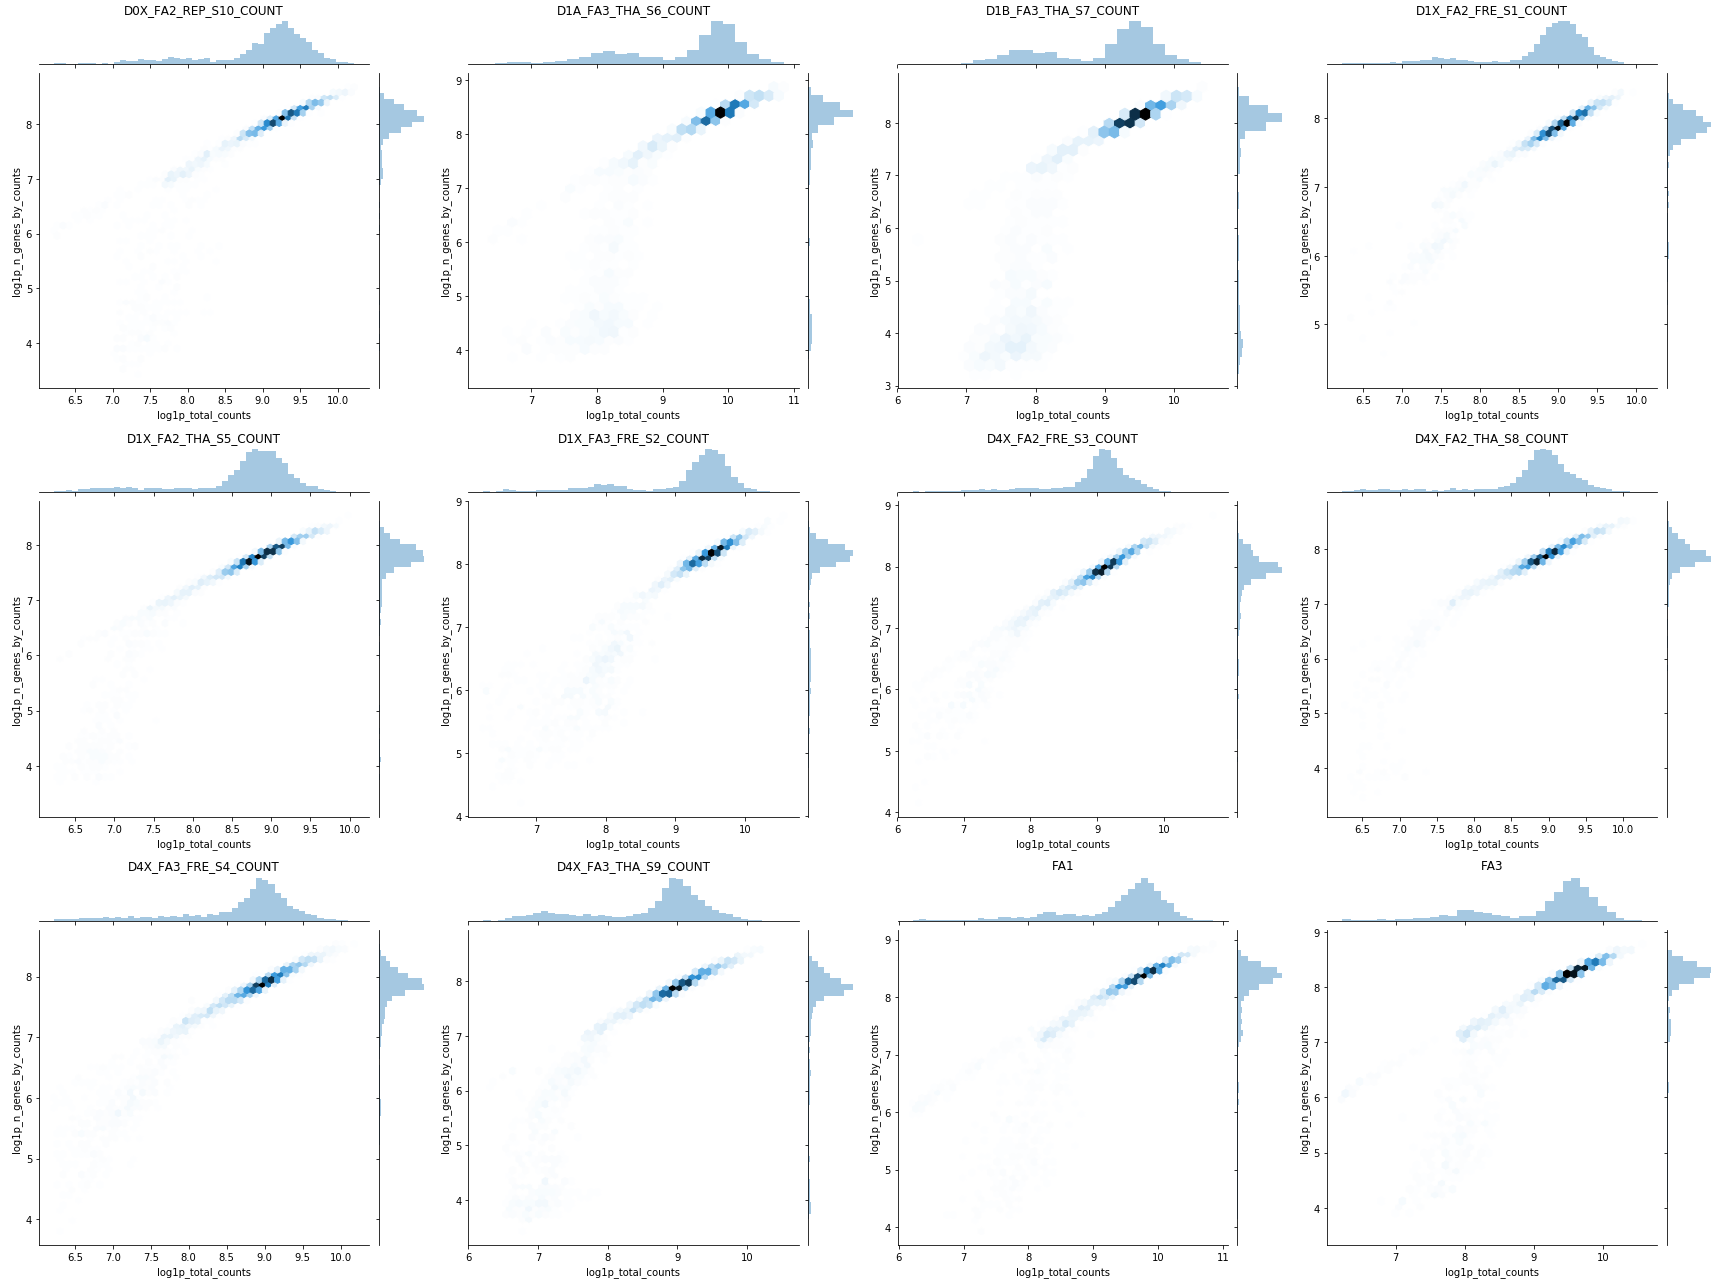

In [19]:
i = 0
fig = plt.figure(figsize=(24,18))
gs = gridspec.GridSpec(3, 4)
for sample in sorted(data_dict):
    g = sns.jointplot("log1p_total_counts",
              "log1p_n_genes_by_counts",
              data=data_dict[sample].obs,
              kind="hex")
    
    SeabornFig2Grid(g, fig, gs[i//4,i%4], title=sample)
    i = i+1
gs.tight_layout(fig)
#gs.update(top=0.7)

plt.savefig('../plots/qc_nofilter.png', transparent=False)
plt.show()

In [114]:
for sample in sorted(data_dict):
    data_dict[sample].write_h5ad(f"../data/adata/no_filter/{sample}.h5ad")

# Filtering & normalisation

In [115]:
for sample in sorted(data_dict):
    sc.pp.filter_cells(data_dict[sample], min_genes=5)
    sc.pp.filter_genes(data_dict[sample], min_cells=50)
    sc.pp.normalize_per_cell(data_dict[sample])
    sc.pp.log1p(data_dict[sample])

In [116]:
for sample in sorted(data_dict):
    data_dict[sample].write_h5ad(f"../data/adata/filtered_normalised/{sample}.h5ad")

# Correlation Analysis

In [464]:
data_dict = {}
gene_list = []
for f in tqdm_notebook(glob.glob("/home/scai/processing_simoncai/10xfreshfrozen/data/adata/no_filter/*")):
    data = sc.read_h5ad(f)
    f = f.replace('/home/scai/processing_simoncai/10xfreshfrozen/data/adata/no_filter/','').replace('.h5ad','')
#     sc.pp.filter_cells(data, min_genes=5)
#     sc.pp.filter_genes(data, min_counts=50)
    #sc.pp.normalize_total(data)
    data_dict[f] = data
    gene_list = data.var_names

In [472]:
combined = pd.DataFrame(index=gene_list)
combined.index.name = 'gene'
for sample in sorted(data_dict):
    sample_name = '_'.join(sample.split('_')[:3])
    combined[sample_name] = np.log10(np.sum(data_dict[sample].to_df().values, axis=0) + 1)

In [473]:
combined = combined[np.sum(combined, axis=1) > 0]
# combined = combined[np.min(combined, axis=1) > 0]

In [474]:
combined.shape

(27287, 12)

## D1A_FA3_THA vs D1B_FA3_THA (controls)

In [564]:
combined[(combined['D1A_FA3_THA']>0)&(combined['D1A_FA3_THA']<0.1)]['D1A_FA3_THA'].values

array([], dtype=float32)

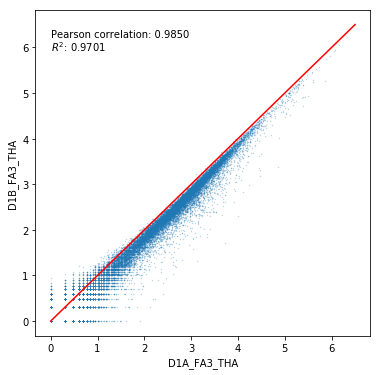

In [570]:
corr_plot(combined, 'D1A_FA3_THA', 'D1B_FA3_THA')

In [447]:
pearsonr(combined['D1A_FA3_THA'], combined['D1B_FA3_THA'])

(0.9849573880578684, 0.0)

In [448]:
pearsonr(combined['D1A_FA3_THA'], combined['D1B_FA3_THA'])[0] ** 2

0.9701410562897783

## D1X_FA2_FRE vs D1X_FA2_THA

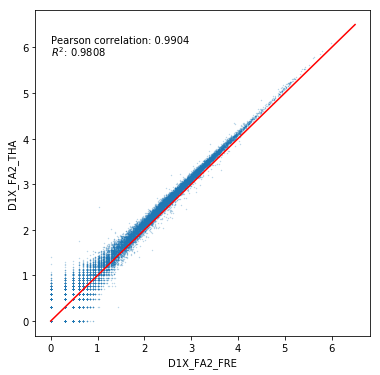

In [571]:
corr_plot(combined, 'D1X_FA2_FRE', 'D1X_FA2_THA')

In [450]:
pearsonr(combined['D1X_FA2_FRE'], combined['D1X_FA2_THA'])

(0.9903676214031566, 0.0)

In [451]:
pearsonr(combined['D1X_FA2_FRE'], combined['D1X_FA2_THA'])[0] ** 2

0.9808280255237461

## D4X_FA2_FRE vs D4X_FA2_THA

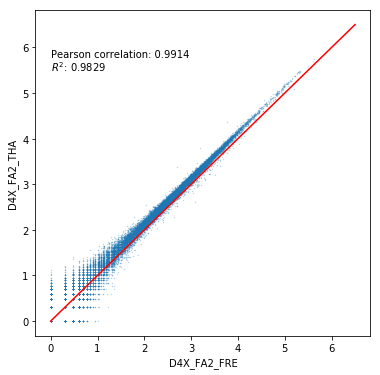

In [572]:
corr_plot(combined, 'D4X_FA2_FRE', 'D4X_FA2_THA')

In [453]:
pearsonr(combined['D4X_FA2_FRE'], combined['D4X_FA2_THA'])

(0.9914136479501705, 0.0)

In [454]:
pearsonr(combined['D4X_FA2_FRE'], combined['D4X_FA2_THA'])[0] ** 2

0.9829010213418646

## D1X_FA3_FRE vs D1X_FA3_THA

### D1X_FA3_FRE vs  D1A_FA3_THA

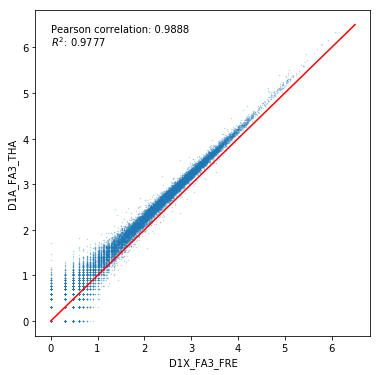

In [573]:
corr_plot(combined, 'D1X_FA3_FRE', 'D1A_FA3_THA')

In [456]:
pearsonr(combined['D1X_FA3_FRE'], combined['D1A_FA3_THA'])

(0.988773344904666, 0.0)

In [457]:
pearsonr(combined['D1X_FA3_FRE'], combined['D1A_FA3_THA'])[0] ** 2

0.9776727275939615

### D1X_FA3_FRE vs D1B_FA3_THA

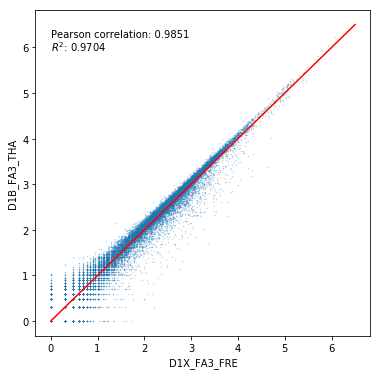

In [574]:
corr_plot(combined, 'D1X_FA3_FRE', 'D1B_FA3_THA')

In [459]:
pearsonr(combined['D1X_FA3_FRE'], combined['D1B_FA3_THA'])

(0.9850879380277385, 0.0)

In [460]:
pearsonr(combined['D1X_FA3_FRE'], combined['D1B_FA3_THA'])[0] ** 2

0.9703982456477416

## D4X_FA3_FRE vs D4X_FA3_THA

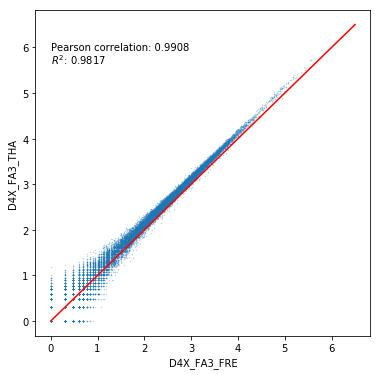

In [575]:
corr_plot(combined, 'D4X_FA3_FRE', 'D4X_FA3_THA')

In [462]:
pearsonr(combined['D4X_FA3_FRE'], combined['D4X_FA3_THA'])

(0.9908066163433049, 0.0)

In [463]:
pearsonr(combined['D4X_FA3_FRE'], combined['D4X_FA3_THA'])[0] ** 2

0.981697750989669

# Cell EDA

## Median UMI per cell

In [523]:
median_frozen = []
median_frozen.append(
    pd.DataFrame(data_dict['D1A_FA3_THA_S6_COUNT'].obs['total_counts'].describe()))
median_frozen.append(
    pd.DataFrame(data_dict['D1B_FA3_THA_S7_COUNT'].obs['total_counts'].describe()))
median_frozen.append(
    pd.DataFrame(data_dict['D1X_FA2_THA_S5_COUNT'].obs['total_counts'].describe()))
median_frozen.append(
    pd.DataFrame(data_dict['D4X_FA2_THA_S8_COUNT'].obs['total_counts'].describe()))
median_frozen.append(
    pd.DataFrame(data_dict['D4X_FA3_THA_S9_COUNT'].obs['total_counts'].describe()))
median_frozen_df = pd.concat(median_frozen, axis=1)
median_frozen_df.columns = [
        'D1A_FA3_THA', 'D1B_FA3_THA', 'D1X_FA2_THA', 'D4X_FA2_THA',
        'D4X_FA3_THA'
    ]

median_frozen_df

,D1A_FA3_THA,D1B_FA3_THA,D1X_FA2_THA,D4X_FA2_THA,D4X_FA3_THA
count,3391.000000,3485.000000,6241.000000,5617.000000,4693.000000
mean,15410.496094,10113.422852,6672.742188,7646.527832,7348.685059
std,9704.859375,6092.403320,3246.864014,3721.746582,4395.135254
min,526.000000,503.000000,507.000000,505.000000,501.000000
25%,5339.000000,3697.000000,5009.000000,5870.000000,4062.000000
50%,16496.000000,10711.000000,6752.000000,7536.000000,7485.000000
75%,21720.500000,14061.000000,8546.000000,9394.000000,9637.000000
max,51135.000000,38596.000000,23334.000000,28475.000000,37123.000000


In [524]:
median_fresh = []
median_fresh.append(
    pd.DataFrame(
        data_dict['D1X_FA2_FRE_S1_COUNT'].obs['total_counts'].describe()))
median_fresh.append(
    pd.DataFrame(
        data_dict['D1X_FA3_FRE_S2_COUNT'].obs['total_counts'].describe()))
median_fresh.append(
    pd.DataFrame(
        data_dict['D4X_FA2_FRE_S3_COUNT'].obs['total_counts'].describe()))
median_fresh.append(
    pd.DataFrame(
        data_dict['D4X_FA3_FRE_S4_COUNT'].obs['total_counts'].describe()))

median_fresh_df = pd.concat(median_fresh, axis=1)
median_fresh_df.columns = [
    'D1X_FA2_FRE', 'D1X_FA3_FRE', 'D4X_FA2_FRE', 'D4X_FA3_FRE'
]

median_fresh_df

,D1X_FA2_FRE,D1X_FA3_FRE,D4X_FA2_FRE,D4X_FA3_FRE
count,3987.000000,2734.000000,3550.000000,3439.000000
mean,7793.993652,11267.464844,8757.341797,7278.457031
std,3410.213623,5790.290039,4302.022949,3713.042236
min,505.000000,514.000000,508.000000,505.000000
25%,6245.000000,7709.250000,6641.250000,5013.000000
50%,8030.000000,12173.500000,8760.500000,7458.000000
75%,9876.000000,15050.250000,10770.750000,9250.500000
max,23675.000000,38207.000000,45956.000000,26378.000000


## Median genes per cell

In [525]:
median_frozen = []
median_frozen.append(
    pd.DataFrame(data_dict['D1A_FA3_THA_S6_COUNT'].obs['n_genes_by_counts'].describe()))
median_frozen.append(
    pd.DataFrame(data_dict['D1B_FA3_THA_S7_COUNT'].obs['n_genes_by_counts'].describe()))
median_frozen.append(
    pd.DataFrame(data_dict['D1X_FA2_THA_S5_COUNT'].obs['n_genes_by_counts'].describe()))
median_frozen.append(
    pd.DataFrame(data_dict['D4X_FA2_THA_S8_COUNT'].obs['n_genes_by_counts'].describe()))
median_frozen.append(
    pd.DataFrame(data_dict['D4X_FA3_THA_S9_COUNT'].obs['n_genes_by_counts'].describe()))
median_frozen_df = pd.concat(median_frozen, axis=1)
median_frozen_df.columns = [
        'D1A_FA3_THA', 'D1B_FA3_THA', 'D1X_FA2_THA', 'D4X_FA2_THA',
        'D4X_FA3_THA'
    ]

median_frozen_df

,D1A_FA3_THA,D1B_FA3_THA,D1X_FA2_THA,D4X_FA2_THA,D4X_FA3_THA
count,3391.000000,3485.000000,6241.000000,5617.000000,4693.000000
mean,3279.352109,2459.618077,2227.790098,2492.817696,2286.559983
std,1902.414329,1491.104703,902.832185,938.684880,1180.372386
min,34.000000,24.000000,27.000000,28.000000,30.000000
25%,1603.000000,978.000000,1949.000000,2190.000000,1701.000000
50%,3968.000000,2982.000000,2375.000000,2570.000000,2548.000000
75%,4665.000000,3535.000000,2785.000000,2986.000000,3007.000000
max,7088.000000,5858.000000,5089.000000,5523.000000,5890.000000


In [526]:
median_fresh = []
median_fresh.append(
    pd.DataFrame(
        data_dict['D1X_FA2_FRE_S1_COUNT'].obs['n_genes_by_counts'].describe()))
median_fresh.append(
    pd.DataFrame(
        data_dict['D1X_FA3_FRE_S2_COUNT'].obs['n_genes_by_counts'].describe()))
median_fresh.append(
    pd.DataFrame(
        data_dict['D4X_FA2_FRE_S3_COUNT'].obs['n_genes_by_counts'].describe()))
median_fresh.append(
    pd.DataFrame(
        data_dict['D4X_FA3_FRE_S4_COUNT'].obs['n_genes_by_counts'].describe()))

median_fresh_df = pd.concat(median_fresh, axis=1)
median_fresh_df.columns = [
    'D1X_FA2_FRE', 'D1X_FA3_FRE', 'D4X_FA2_FRE', 'D4X_FA3_FRE'
]

median_fresh_df

,D1X_FA2_FRE,D1X_FA3_FRE,D4X_FA2_FRE,D4X_FA3_FRE
count,3987.000000,2734.000000,3550.000000,3439.000000
mean,2436.792074,2849.652524,2729.372958,2369.375109
std,892.915566,1326.781894,991.670620,953.497290
min,71.000000,67.000000,63.000000,44.000000
25%,2215.000000,2443.750000,2400.250000,1990.500000
50%,2611.000000,3278.500000,2847.000000,2532.000000
75%,2989.000000,3739.500000,3247.000000,2927.500000
max,4691.000000,6407.000000,6839.000000,5091.000000


# Gene EDA

In [521]:
median_frozen = []
median_frozen.append(
    pd.DataFrame(data_dict['D1A_FA3_THA_S6_COUNT'].var['total_counts'].describe()))
median_frozen.append(
    pd.DataFrame(data_dict['D1B_FA3_THA_S7_COUNT'].var['total_counts'].describe()))
median_frozen.append(
    pd.DataFrame(data_dict['D1X_FA2_THA_S5_COUNT'].var['total_counts'].describe()))
median_frozen.append(
    pd.DataFrame(data_dict['D4X_FA2_THA_S8_COUNT'].var['total_counts'].describe()))
median_frozen.append(
    pd.DataFrame(data_dict['D4X_FA3_THA_S9_COUNT'].var['total_counts'].describe()))
median_frozen_df = pd.concat(median_frozen, axis=1)
median_frozen_df.columns = [
        'D1A_FA3_THA', 'D1B_FA3_THA', 'D1X_FA2_THA', 'D4X_FA2_THA',
        'D4X_FA3_THA'
    ]

median_frozen_df

,D1A_FA3_THA,D1B_FA3_THA,D1X_FA2_THA,D4X_FA2_THA,D4X_FA3_THA
count,3.353800e+04,3.353800e+04,3.353800e+04,33538.000000,33538.000000
mean,1.558122e+03,1.050897e+03,1.241701e+03,1280.629272,1028.295166
std,2.119165e+04,1.554579e+04,1.364381e+04,11024.714844,10461.836914
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,1.200000e+01,7.000000e+00,8.000000e+00,6.000000,6.000000
75%,4.130000e+02,2.430000e+02,3.440000e+02,384.000000,297.000000
max,2.132248e+06,1.687549e+06,1.270253e+06,613531.000000,877213.000000


In [522]:
median_fresh = []
median_fresh.append(
    pd.DataFrame(
        data_dict['D1X_FA2_FRE_S1_COUNT'].var['total_counts'].describe()))
median_fresh.append(
    pd.DataFrame(
        data_dict['D1X_FA3_FRE_S2_COUNT'].var['total_counts'].describe()))
median_fresh.append(
    pd.DataFrame(
        data_dict['D4X_FA2_FRE_S3_COUNT'].var['total_counts'].describe()))
median_fresh.append(
    pd.DataFrame(
        data_dict['D4X_FA3_FRE_S4_COUNT'].var['total_counts'].describe()))

median_fresh_df = pd.concat(median_fresh, axis=1)
median_fresh_df.columns = [
    'D1X_FA2_FRE', 'D1X_FA3_FRE', 'D4X_FA2_FRE', 'D4X_FA3_FRE'
]

median_fresh_df

,D1X_FA2_FRE,D1X_FA3_FRE,D4X_FA2_FRE,D4X_FA3_FRE
count,33538.000000,3.353800e+04,33538.000000,33538.000000
mean,926.540771,9.185120e+02,926.953308,746.328064
std,10294.678711,1.178343e+04,8452.269531,7416.173340
min,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000,0.000000
50%,6.000000,6.000000e+00,4.000000,4.000000
75%,245.000000,2.280000e+02,282.000000,218.000000
max,963882.000000,1.164392e+06,566140.000000,592485.000000
